In [1]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
from google.colab import files
 
 
uploaded = files.upload()

Saving monthly-beer-production-in-austr.csv to monthly-beer-production-in-austr.csv


In [3]:
ds = pd.read_csv(io.BytesIO(uploaded['monthly-beer-production-in-austr.csv']))

In [9]:
ds.shape

(476, 2)

In [4]:
ds['Date']=ds.Month

In [5]:
ds['Year'] = ds['Month'].apply(lambda x: str(x).split('-')[0])

In [6]:
ds['Month'] = ds['Month'].apply(lambda x: str(x).split('-')[1])

## Serie temporal:


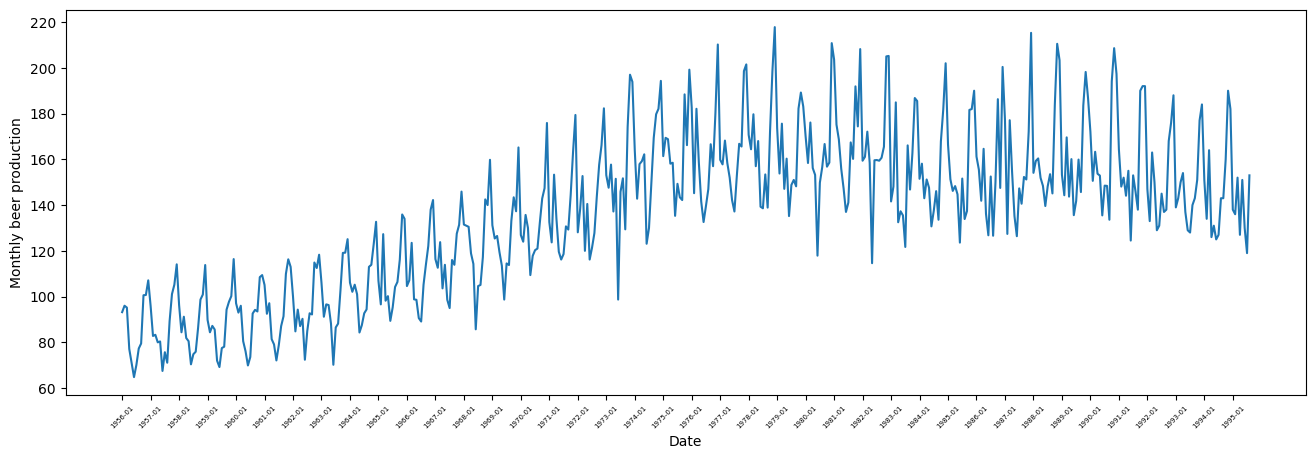

In [57]:
plt.plot(ds.Date, ds['Monthly beer production'])
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Monthly beer production")
plt.rcParams['figure.figsize'] = [16,5]
locs, labels = plt.xticks()
new_locs = locs[::12]
new_labels = labels[::12]
plt.xticks(new_locs, new_labels)
plt.show()

##Comparación de ciclos

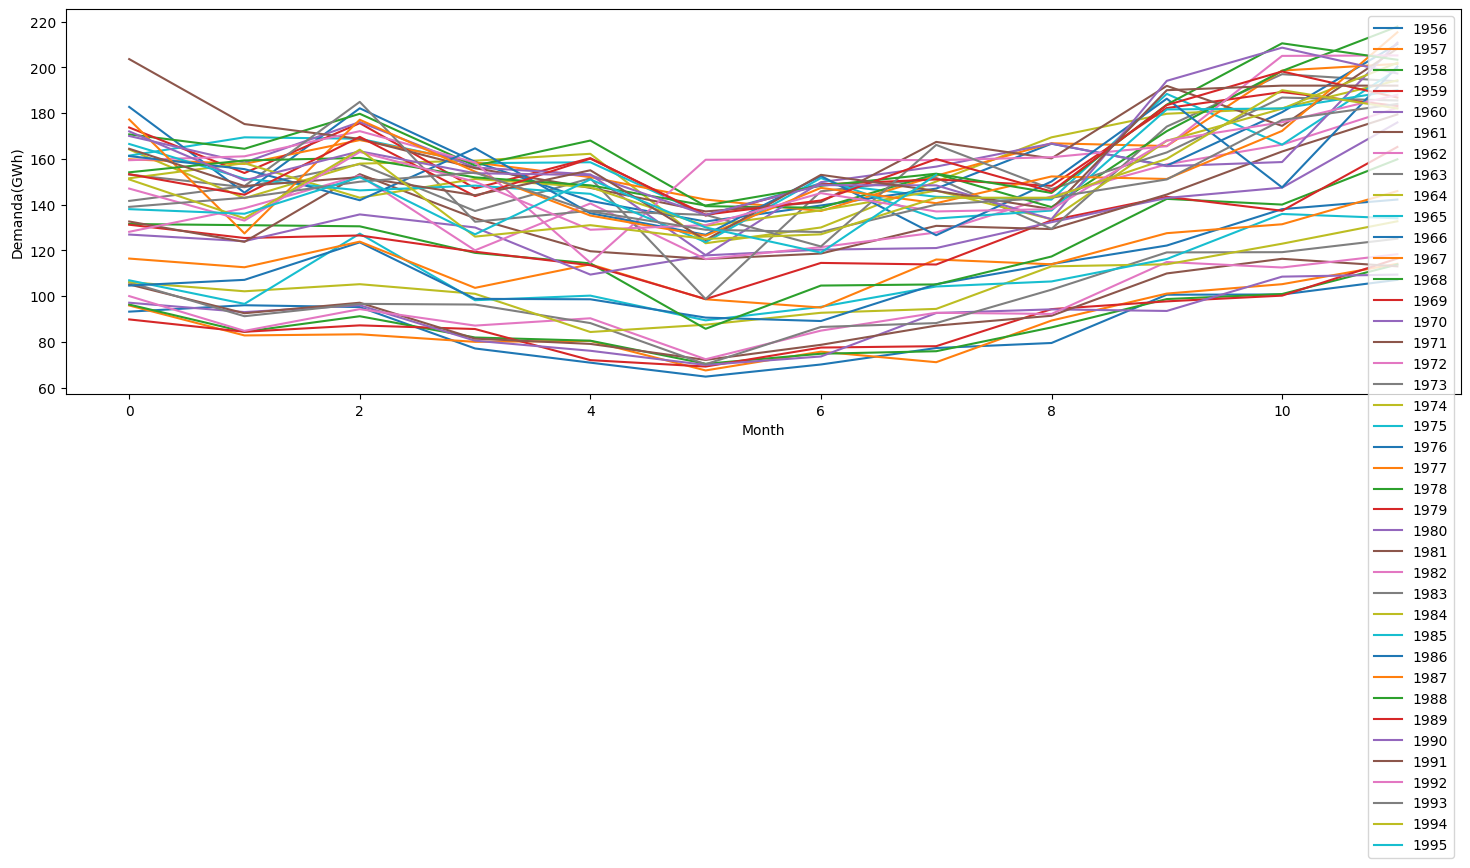

In [14]:
plt.figure(figsize=(18, 5))
yearly_data = ds.groupby(ds.Year)['Monthly beer production']

# Loop through each month and plot the data for that month across all years
for month, data in yearly_data:
    plt.plot(data.values, label=str(month))

# Add axis labels and legend
plt.xlabel('Month')
plt.ylabel('Demanda(GWh)')
plt.legend(loc='upper right')

##Crecimiento la variable objetivo agrupada por mes:

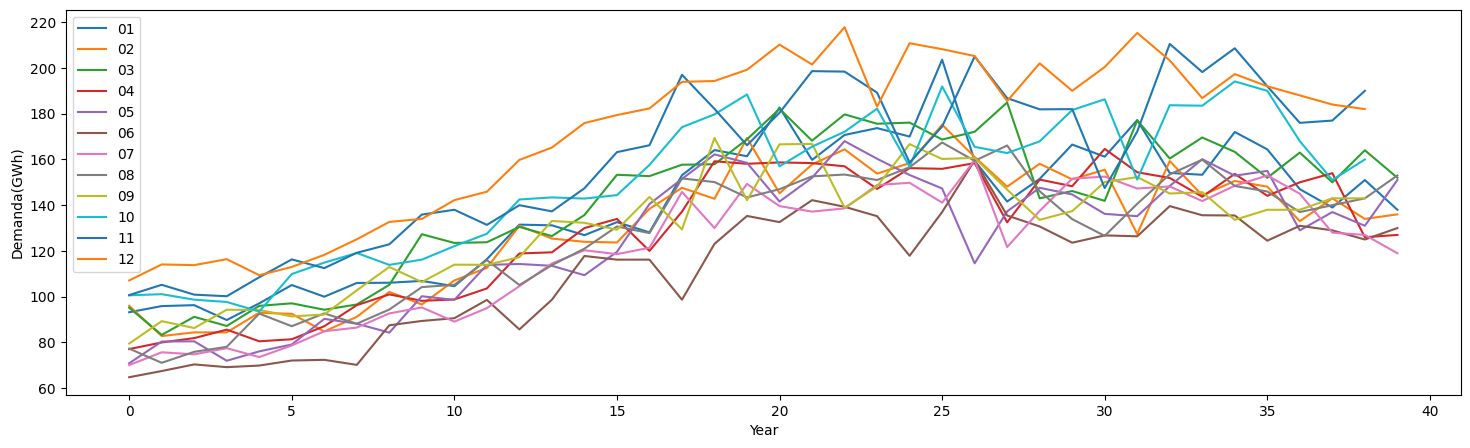

In [15]:
plt.figure(figsize=(18, 5))
monthly_data = ds.groupby(ds.Month)['Monthly beer production']

# Loop through each month and plot the data for that month across all years
for year, data in monthly_data:
    plt.plot(data.values, label=str(year))

# Add axis labels and legend
plt.xlabel('Year')
plt.ylabel('Demanda(GWh)')
plt.legend()

<Axes: xlabel='Year', ylabel='Monthly beer production'>

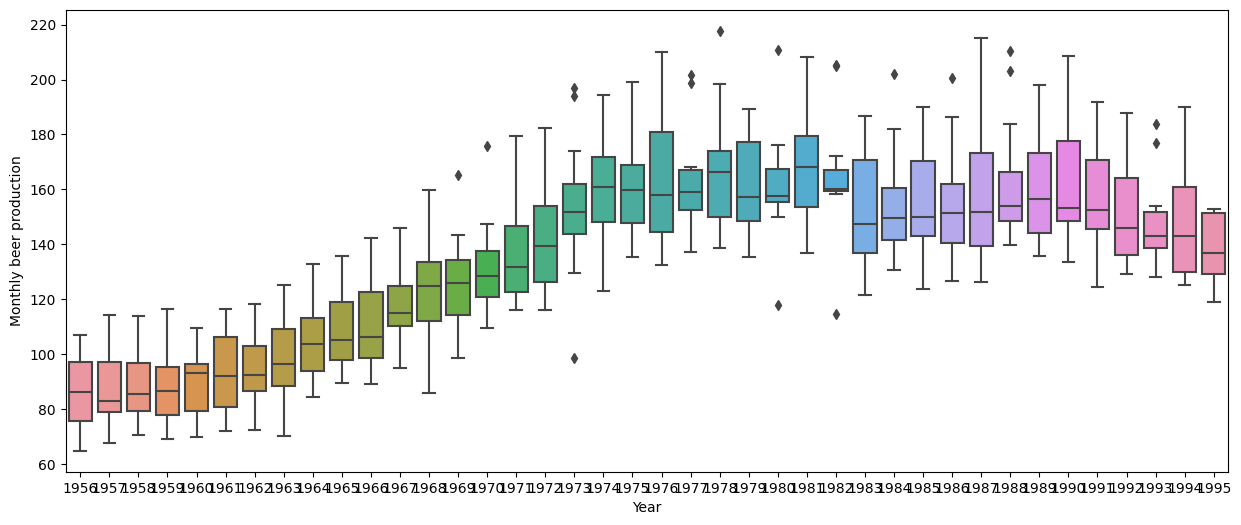

In [16]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data = ds , x = 'Year' ,y = 'Monthly beer production')

<Axes: xlabel='Month', ylabel='Monthly beer production'>

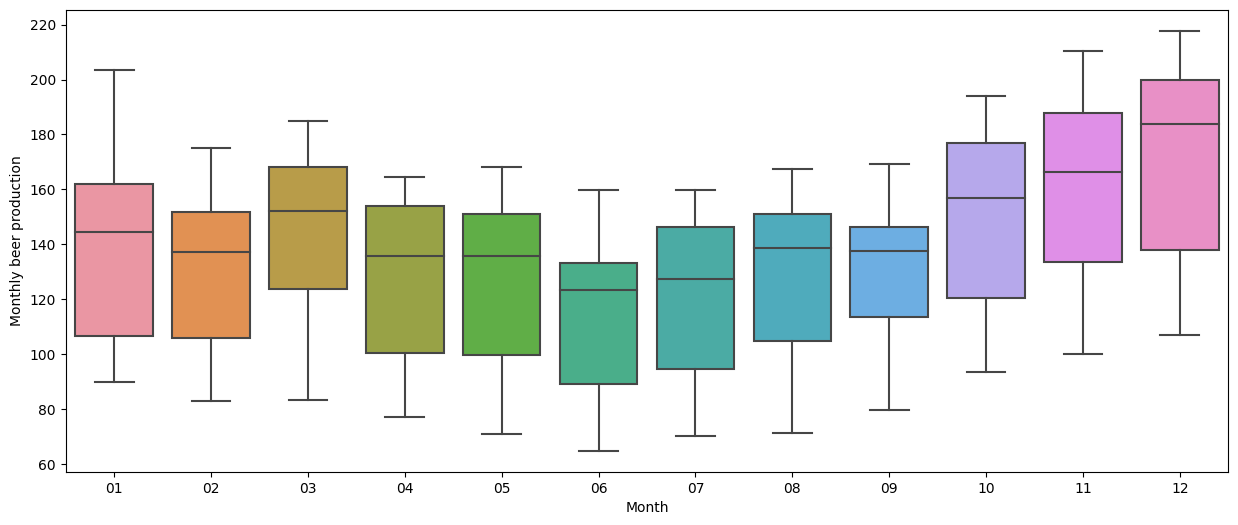

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data = ds , x = 'Month' ,y = 'Monthly beer production')

In [7]:
import statsmodels.api as sm

# separo datos en training y testing

In [8]:
ds_train = ds.head(384)

In [9]:
ds_test = ds.tail(92)

## Descomposición en 4 componentes

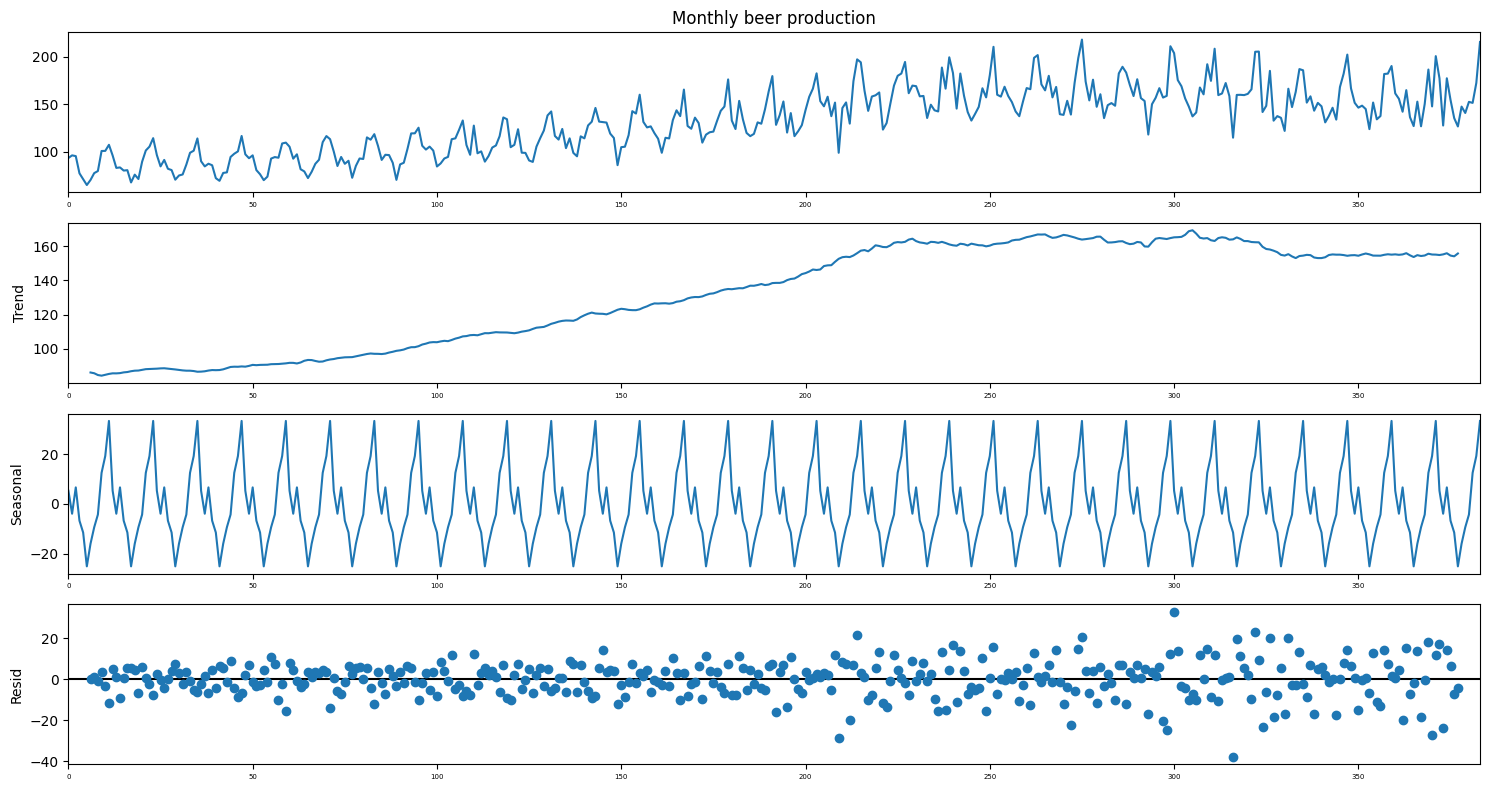

In [21]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
rcParams['axes.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['xtick.labelsize'] = 5
decomposition = sm.tsa.seasonal_decompose(ds_train['Monthly beer production'], model='additive',period=12)
decomp = decomposition.plot()

##Descripción:

En los gráficos anteriores se puede apreciar la producción de cerveza en Australia mes a mes a lo largo de los años en miles de hectolitros.

Se puede observar un comportamiento cíclico año a año, lo que nos da a enteder que es una serie estacional, con máximos locales al ciclo entre los primeros y úlimos meses del año, y mínimos entre los meses de Mayo, Junio, Julio y Agosto. Observando el gráfico de la serie y el de sus cíclos comparados, podemos afirmar que no es una serie estacionaria debido a que no tiene media constante. 

Observando la tendencia en la descomposición de cuatro componente, se aprecia un aparente crecimiento en la media de la variable objetivo hasta (aprox) el año 1975, y parece mantenerse cuasi contstante.

Respecto a la varianza, esta tiene una tendencia creciente con el avance del tiempo y se puede apreciar al comparar difencia entre el máximo y mínimo de cada ciclo.

También se puede apreciar que a partir del año 1990 (aproximadamante) la tendencia al crecimiento de la media disminuye.

log de prod

In [10]:
ds_train['prod_log'] = np.log(ds_train['Monthly beer production'])

<ipython-input-10-bf1275490031>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_train['prod_log'] = np.log(ds_train['Monthly beer production'])


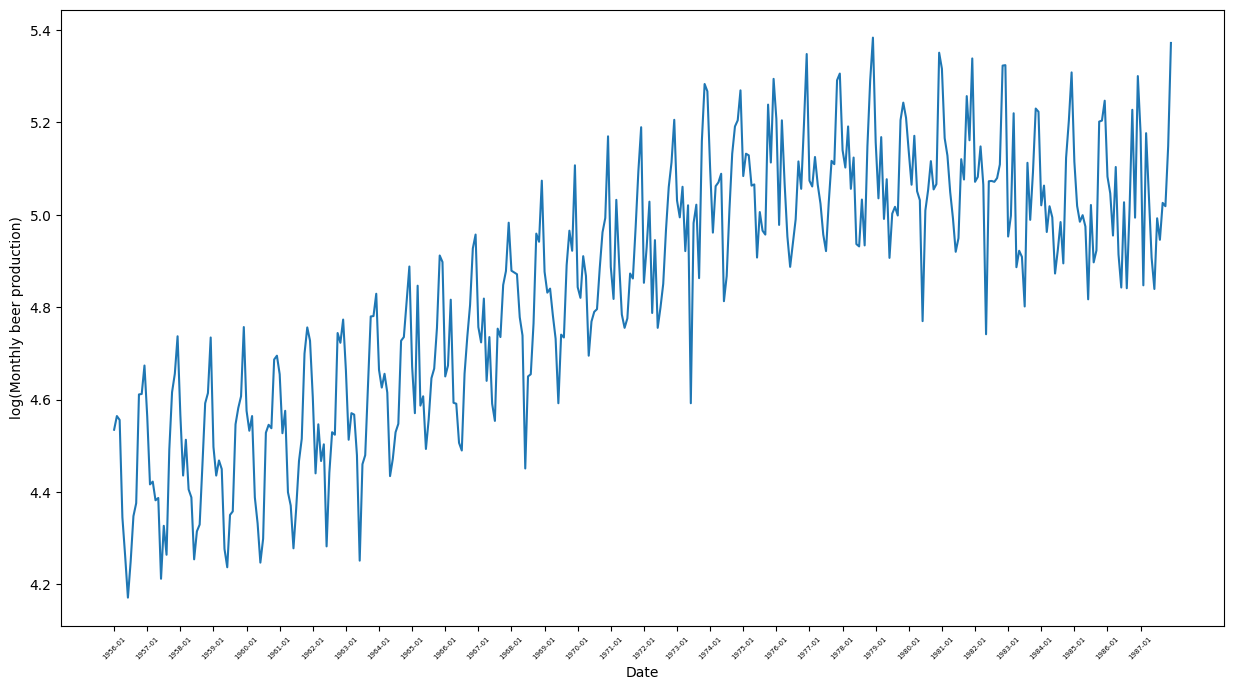

In [23]:
plt.plot(ds_train.Date, ds_train['prod_log'])
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("log(Monthly beer production)")
plt.rcParams['figure.figsize'] = [16,5]
locs, labels = plt.xticks()
new_locs = locs[::12]
new_labels = labels[::12]
plt.xticks(new_locs, new_labels)
plt.show()

##Aplicar logaritmo a la variable objetivo permite obtener una varianza que aparenta ser constante


##Modelo deteminístico :

##Comienzo con un modelo cuadrático

In [11]:
from scipy.optimize import curve_fit
from datetime import datetime

In [12]:
def best_quadratic_fit(x, y):
    def quadratic(x, a, b, c):
        return a * x**2 + b * x + c
    
    # Use curve_fit to find the best-fit parameters
    popt, pcov = curve_fit(quadratic, x, y)
    
    # Return the coefficients of the quadratic function
    return popt

In [13]:
cuad = best_quadratic_fit(ds_train.index, ds_train['prod_log'])

In [14]:
cuad

array([-6.74416387e-06,  4.59697811e-03,  4.29682989e+00])

In [15]:
def plot_quadratic_fit(x, y, coeffs):
    # Create a range of x values to plot the function
    x_plot = np.linspace(-10, 400, 100)
    
    # Evaluate the quadratic function at the x values
    y_plot = coeffs[0] * x_plot**2 + coeffs[1] * x_plot + coeffs[2]
    
    # Plot the function and data points
    plt.plot(x, y, label='Data points')
    plt.plot(x_plot, y_plot, label='Quadratic fit')
    
    # Set axis labels and legend
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    
    # Show the plot
    plt.show()

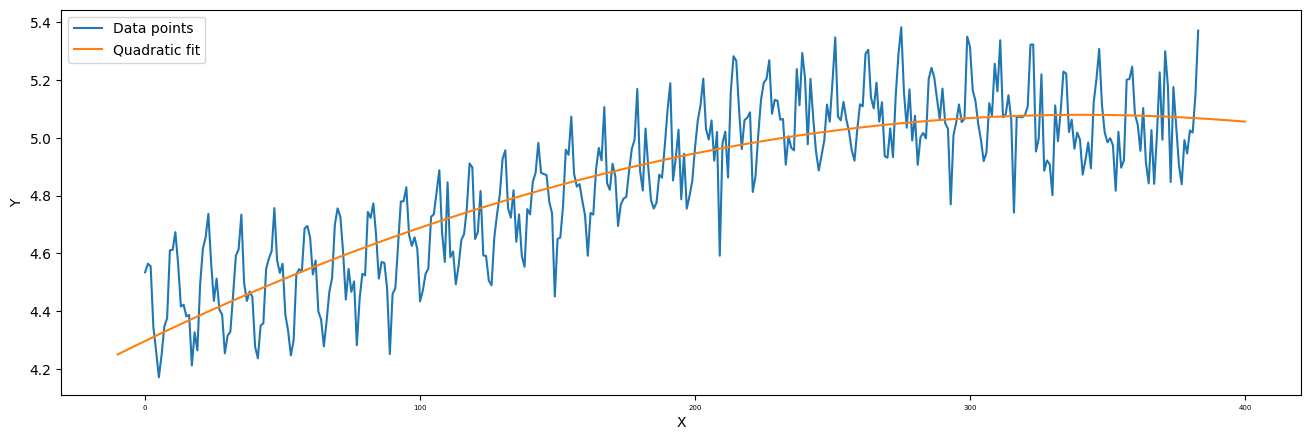

In [29]:
plot_quadratic_fit(ds_train.index, ds_train['prod_log'], cuad)

Se aproxima bien a la tenedncia, ahora agrego componente cíclica

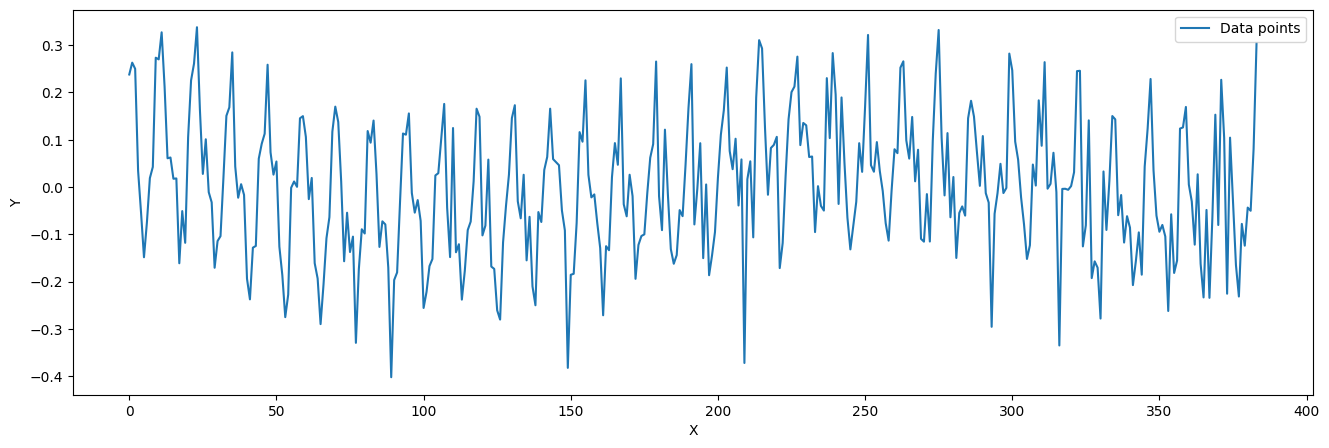

In [17]:
coeffs = cuad
x_plot = np.linspace(0, 384, 384)

# Evaluate the quadratic function at the x values
y_plot = coeffs[0] * x_plot**2 + coeffs[1] * x_plot + coeffs[2]

# Plot the function and data points
plt.plot(ds_train.index, ds_train['prod_log'] - y_plot, label='Data points')

# Set axis labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.rcParams['figure.figsize'] = [16,5]

# Show the plot
plt.show()

## En este gráfico observamos el resultado de aplicar el logaritmo a la variable objetivo (para reducir la varianza) y luego retarle la función cuadrática que se ajustó mejor al modelo; como resultado obtuvimos media cuasi constante al igual que la varianza (lo que se buscaba)

In [18]:
ds_train['cuadr']  = y_plot

<ipython-input-18-603d7a4721c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_train['cuadr']  = y_plot


In [19]:
ds_train['log_minus_cuadr'] = ds_train['prod_log'] - y_plot

<ipython-input-19-9803eb98f072>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_train['log_minus_cuadr'] = ds_train['prod_log'] - y_plot


In [20]:
betas = [None]*12

In [22]:
for i in range(9):
  betas[i] = ds_train[ds_train['Month'] == "0"+str(i+1)]['log_minus_cuadr'].sum() / len(ds_train[ds_train['Month'] == "0"+str(i+1)]['log_minus_cuadr'])

In [21]:
for i in range(3):
  betas[i+9] = ds_train[ds_train['Month'] == str(i+10)]['log_minus_cuadr'].sum() / len(ds_train[ds_train['Month'] == str(i+10)]['log_minus_cuadr'])

In [23]:
betas

[0.05152260505730086,
 -0.016938826139357543,
 0.05715526166216228,
 -0.048749075950247744,
 -0.09168075898971234,
 -0.21028349581667902,
 -0.12543912749749586,
 -0.07220006781246532,
 -0.02263138192180822,
 0.0960318980469945,
 0.14288357581920066,
 0.23346563165687922]

In [24]:
ds_train['cuadr_minus_betas'] = 0

<ipython-input-24-b7b48e7dc700>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_train['cuadr_minus_betas'] = 0


In [25]:
for i in ds_train.index:
  ds_train['cuadr_minus_betas'][i] = ds_train['cuadr'][i] +  betas[int(ds_train['Month'][i]) - 1]

<ipython-input-25-f67d35d0d46c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_train['cuadr_minus_betas'][i] = ds_train['cuadr'][i] +  betas[int(ds_train['Month'][i]) - 1]


In [26]:
 ds_train['cuadr_mas_betas'] =  ds_train['cuadr_minus_betas']

<ipython-input-26-eea115f9290c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_train['cuadr_mas_betas'] =  ds_train['cuadr_minus_betas']


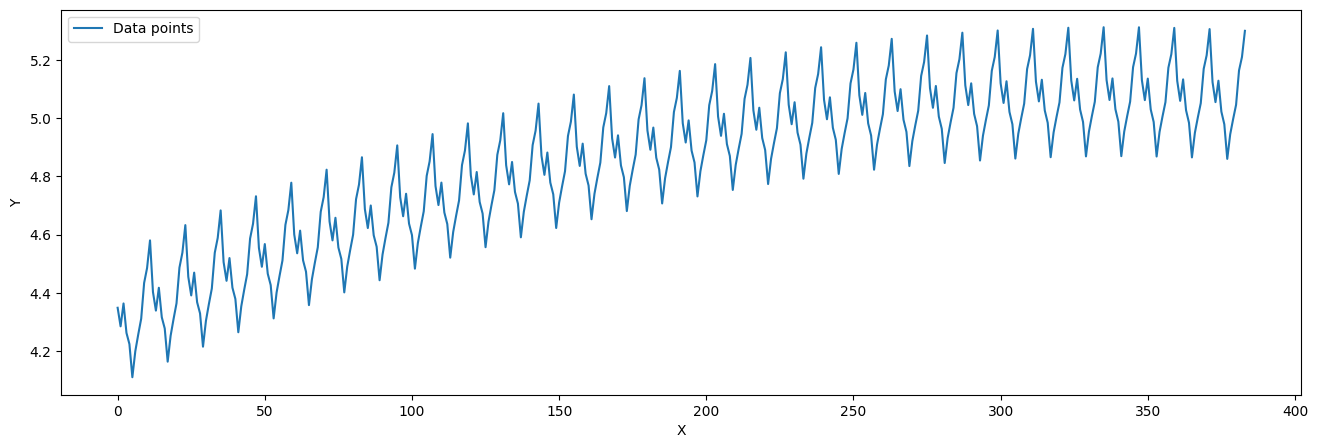

In [27]:
plt.plot(ds_train.index, ds_train['cuadr_mas_betas'], label='Data points')

# Set axis labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.rcParams['figure.figsize'] = [16,5]

# Show the plot
plt.show()

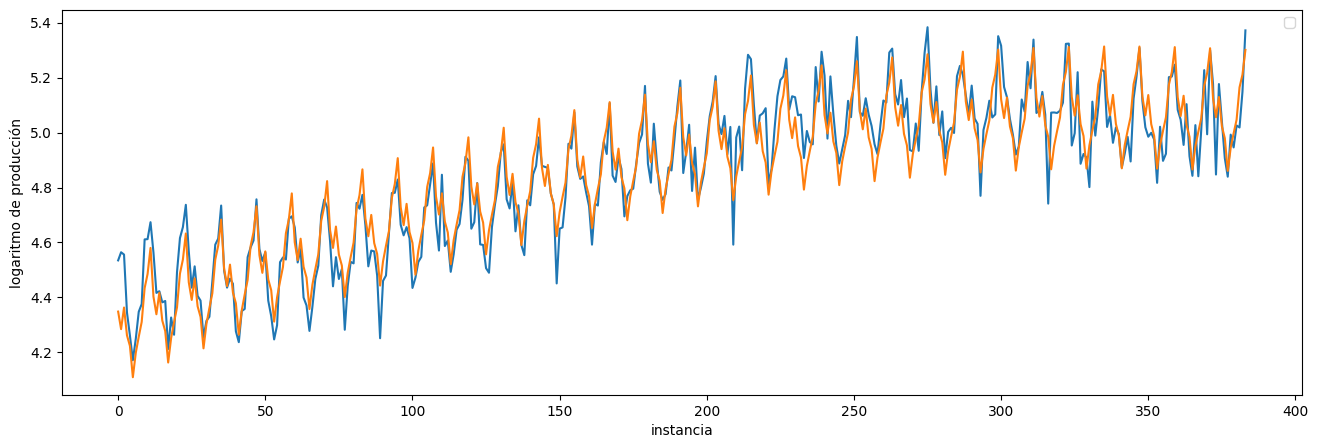

In [28]:
plt.plot(ds_train.index,ds_train['prod_log'], ds_train['cuadr_mas_betas'])

# Set axis labels and legend
plt.xlabel('instancia')
plt.ylabel('logaritmo de producción')
plt.legend()
plt.rcParams['figure.figsize'] = [16,5]

# Show the plot
plt.show()

### En el gráfico anterior observamos en azul el logaritmo de la variable objetivo y en naranja al modelo deterministico generado compuesto por una componente cuadrática y una componente cíclica.

## Preprocesamiento por Box-Cox

In [29]:
from scipy.stats import boxcox

In [30]:
def plot_boxcox(df, lmbda):
  df['prod_boxcox'] = boxcox(df['Monthly beer production'], lmbda= lmbda)
  plt.plot(df.Date, df['prod_boxcox'])
  plt.xlabel("Date")
  plt.xticks(rotation=45)
  plt.ylabel("Production with boxcox")
  plt.rcParams['figure.figsize'] = [16,5]
  locs, labels = plt.xticks()
  new_locs = locs[::12]
  new_labels = labels[::12]
  plt.xticks(new_locs, new_labels)
  plt.show()

<ipython-input-30-90bcff9b4b54>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prod_boxcox'] = boxcox(df['Monthly beer production'], lmbda= lmbda)


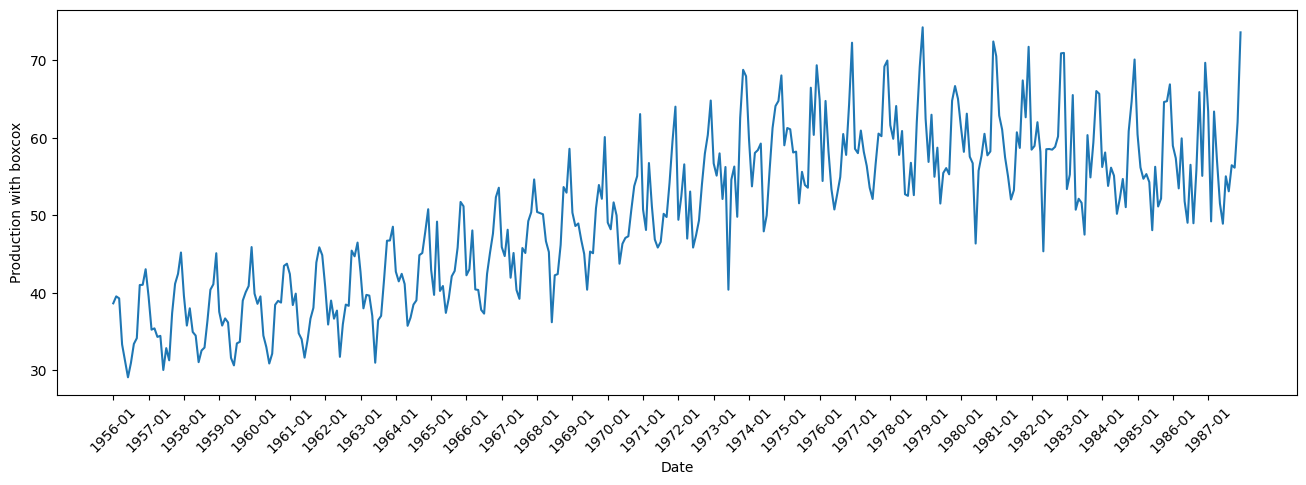

In [31]:
plot_boxcox(ds_train, 0.75)

<ipython-input-43-90bcff9b4b54>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prod_boxcox'] = boxcox(df['Monthly beer production'], lmbda= lmbda)


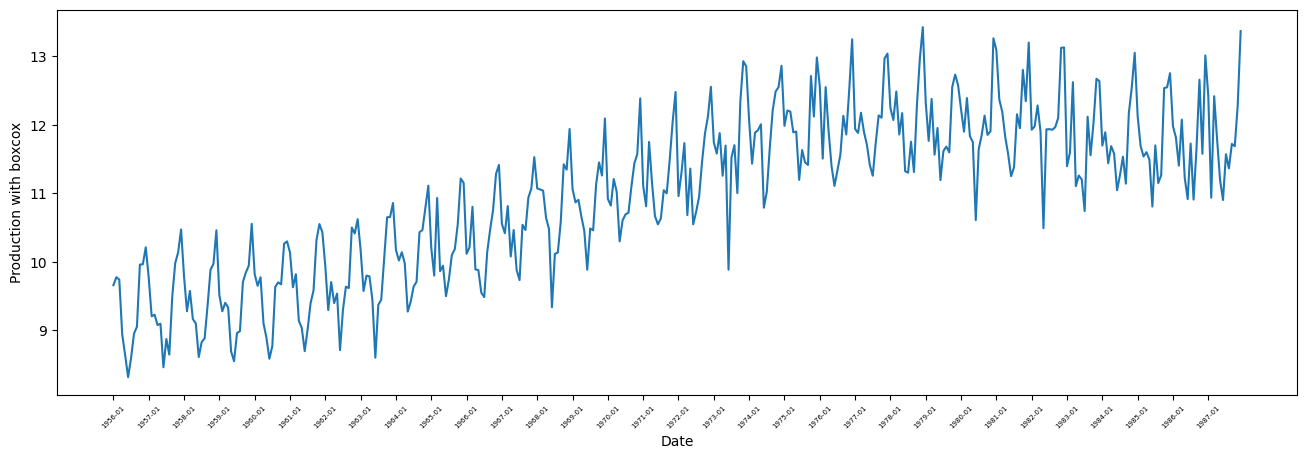

In [45]:
plot_boxcox(ds_train, 0.3)

<ipython-input-30-90bcff9b4b54>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prod_boxcox'] = boxcox(df['Monthly beer production'], lmbda= lmbda)


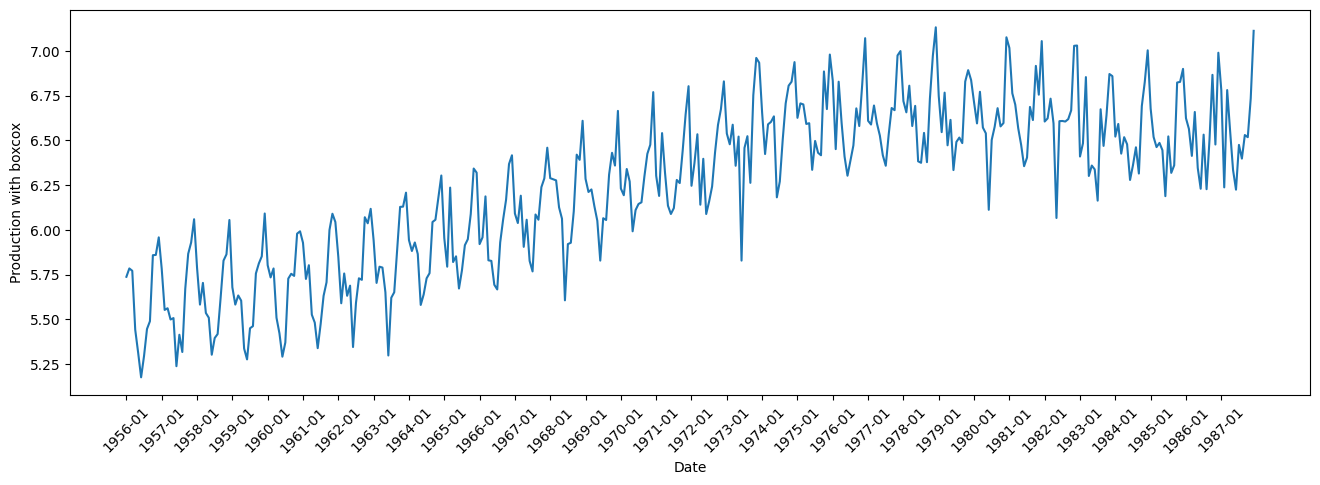

In [32]:
plot_boxcox(ds_train, 0.1)

#Diferenciación:

In [33]:
ds_train['dif'] = 0

<ipython-input-33-d6817371aec4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_train['dif'] = 0


In [34]:
for i in range(383):
  ds_train['dif'][i+1] = ds_train['prod_boxcox'][i+1] - ds_train['prod_boxcox'][i]

<ipython-input-34-c3d0968b89ec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_train['dif'][i+1] = ds_train['prod_boxcox'][i+1] - ds_train['prod_boxcox'][i]


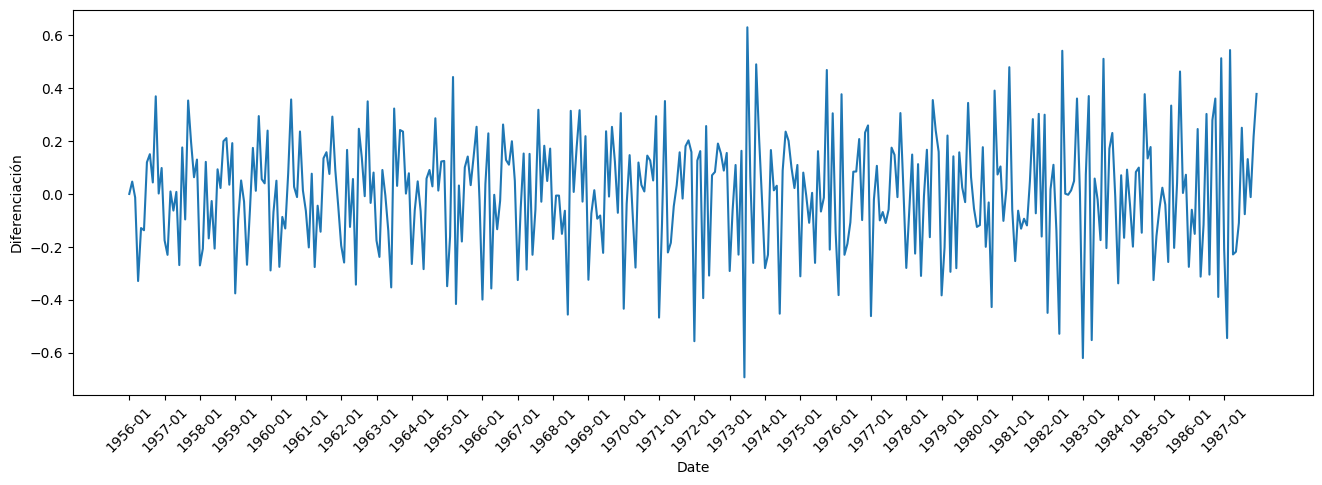

In [35]:
plt.plot(ds_train.Date, ds_train['dif'])
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Diferenciación")
plt.rcParams['figure.figsize'] = [16,5]
locs, labels = plt.xticks()
new_locs = locs[::12]
new_labels = labels[::12]
plt.xticks(new_locs, new_labels)
plt.show()                        

###Habiendo aplicado este otro prepocesamiento boxcox y diferenciación considero que obtuve una serie con media constante (cerca de cero) y varianza constante

##Autocorrelación y correlación parcial

Input original

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


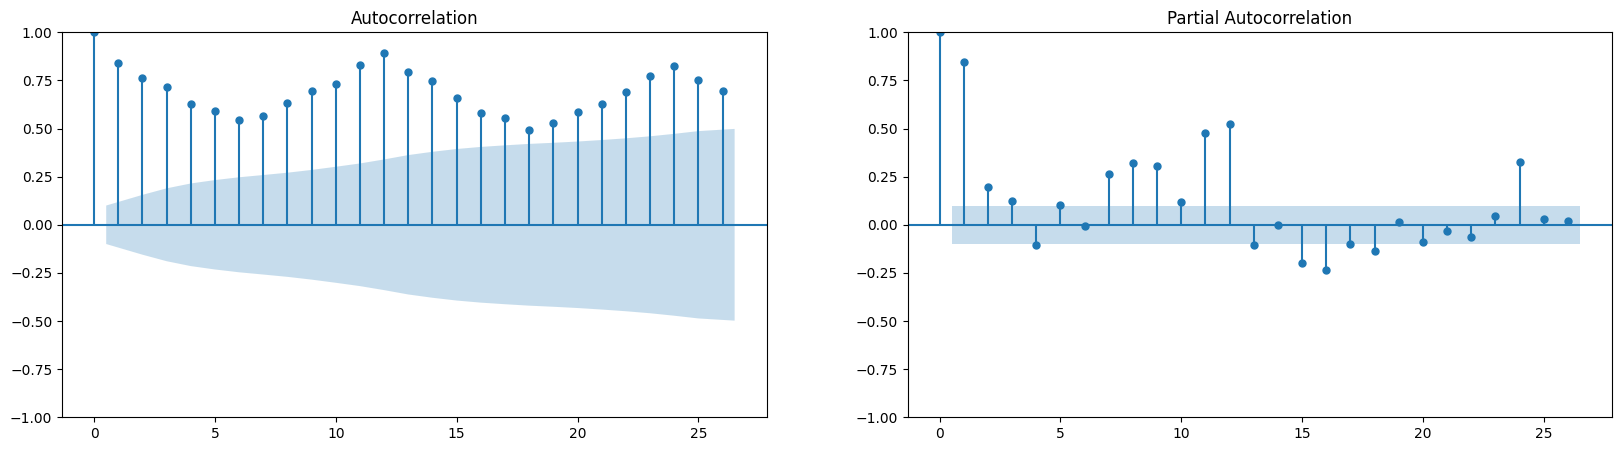

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_acf(ds_train['Monthly beer production'], ax=ax[0])
plot_pacf(ds_train['Monthly beer production'], ax=ax[1])
plt.show()

Input con logaritmo y restado función cuadrática

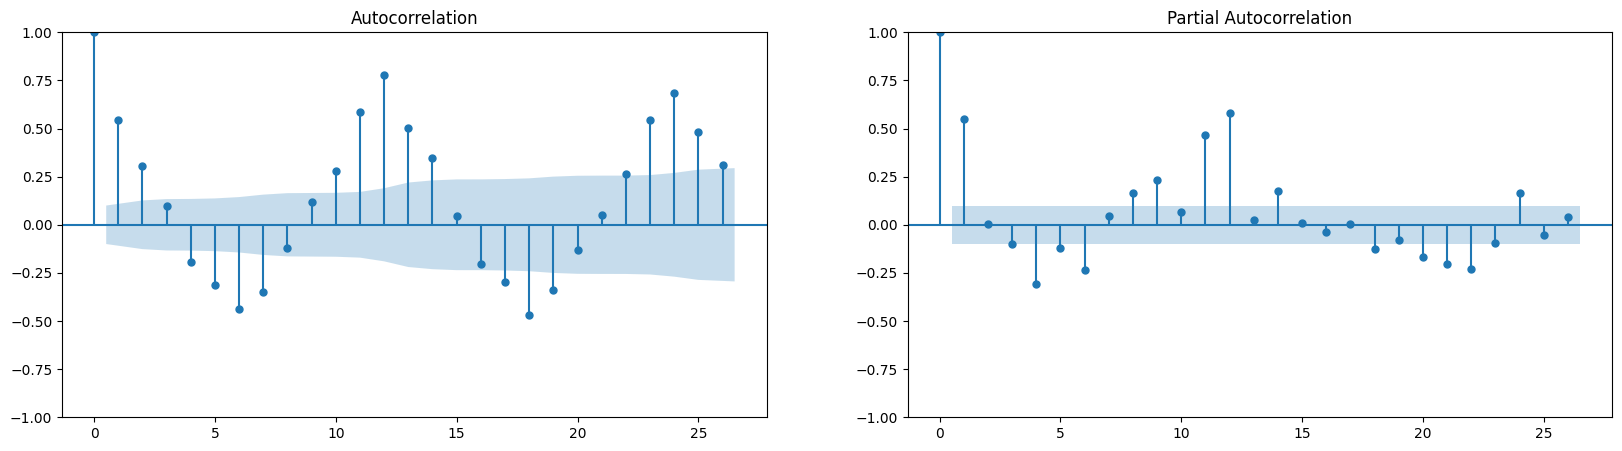

In [37]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_acf(ds_train['log_minus_cuadr'], ax=ax[0])
plot_pacf(ds_train['log_minus_cuadr'], ax=ax[1])
plt.show()

Input con Box-Cox y diferenciación

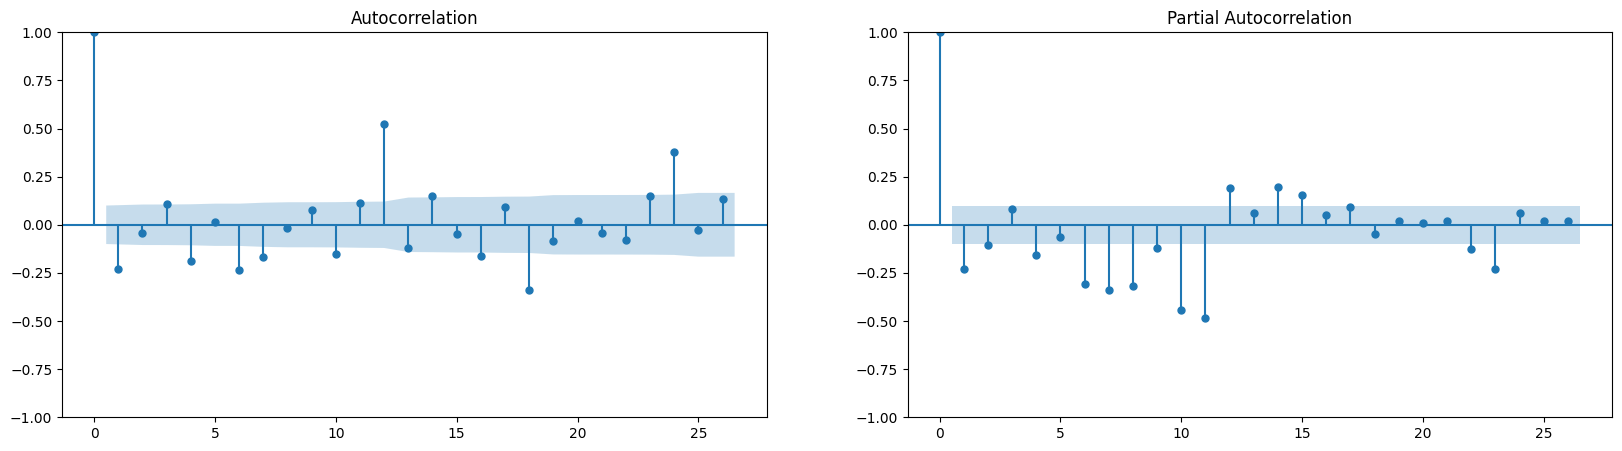

In [38]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_acf(ds_train['dif'], ax=ax[0])
plot_pacf(ds_train['dif'], ax=ax[1])
plt.show()

### En el gráfico de autocorrelación de la serie original nos corrobora, nuevamente, que no es estacionario, ya que a medida que avanzan los lags en ningún momento del gráfico esta se muestra despreciable. Ni siquiera tiene un descenso continuo. En de la serie tras aplicar BoxCox y diferenciación observamos como esta decae a valores muy pequeños con mucha velocidad (mejor resultado que el otro preprocesamiento), nos da indicio de haber obtenido una serie estacionaria.

### El gráfico de autocorrelación de la serie preprocesada nos indica que a partir del lag 2 se empieza a tener autocorrelación despreciable, por lo tanto ajustar un MA de orden 1 (MA(1))



### Test de Dickey-Fuller

In [53]:
from statsmodels.tsa.stattools import adfuller

In [54]:
adfuller(ds_train['dif'])

(-5.732884499835928,
 6.538320768462993e-07,
 16,
 367,
 {'1%': -3.448294490928673,
  '5%': -2.869447722240253,
  '10%': -2.570982681065269},
 -500.4756482970116)

p-valor (6.54*10^-7)< 0.05 ; rechazo el test de hipótesis, es estacionaria de acuerdo con Dickey-Fuller

### Test KPSS

In [55]:
from statsmodels.tsa.stattools import kpss

In [56]:
kpss(ds_train['dif'])

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.005542109158847245,
 0.1,
 0,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

p-valor>0.1 => p-valor> 0.5 => No rechazo test de hipótesis => es estacionaria para el test KPSS

### Ambos test dicen que la función es estacionaria => es estacionaria

## Seleccion de modelos (S)ARIMA

Observando los gráicos de autocorrelación y autocorrelación parcial supongo los parámetros del modelo hasta encontrar uno que se aproxime a mi función